# Using real world data

In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
from google.colab import files

files.upload()

In [4]:
TEMPERATURES_CSV = 'daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data

In [7]:
def parse_data_from_file(filename):

    times = []
    temperatures = []

    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            temperatures.append(float(row[1]))
        times = list(range(len(temperatures)))

    return times, temperatures

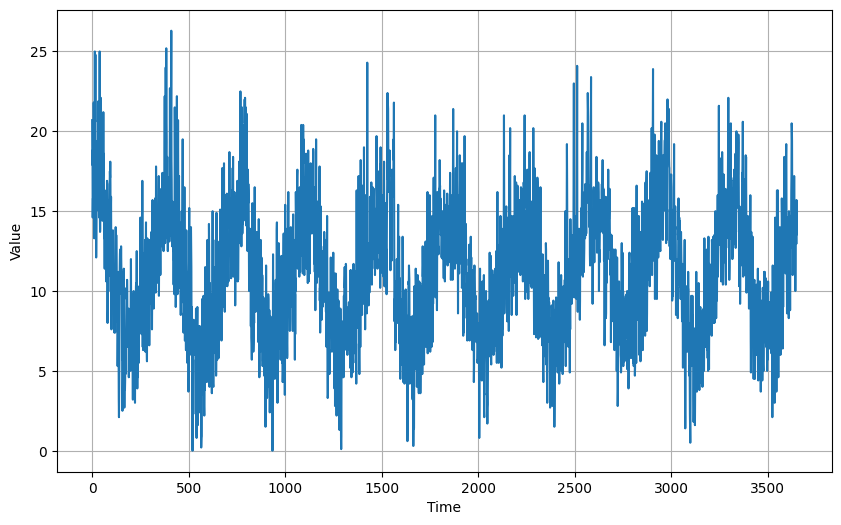

In [9]:
# Test the function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = 'daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

In [10]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [11]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture

In [12]:
def create_uncompiled_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                               strides=1, padding='causal',
                               activation='relu',input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    return model

In [13]:
# Test the uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):

    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)

# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (32, 64)...
1/1 [==============================] - 1s 1s/step
Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate

In [14]:
def adjust_learning_rate(dataset):

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    optimizer = 'adam'
    model.compile(loss='huber',
                  optimizer=optimizer,
                  metrics=["mae"])
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [15]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 10s 59ms/step - loss: 10.0377 - mae: 10.5364 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 6s 71ms/step - loss: 9.4917 - mae: 9.9901 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 6s 74ms/step - loss: 8.6242 - mae: 9.1223 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 5s 60ms/step - loss: 7.4080 - mae: 7.9043 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 6s 75ms/step - loss: 5.7122 - mae: 6.1995 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 5s 68ms/step - loss: 3.8317 - mae: 4.3070 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 5s 59ms/step - loss: 2.7748 - mae: 3.2408 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 6s 74ms/step - loss: 2.1588 - mae: 2.6180 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 5s 64ms/step - loss: 1.9116 - mae: 2.3635 - lr: 

(0.0001, 10.0, 0.0, 10.0)

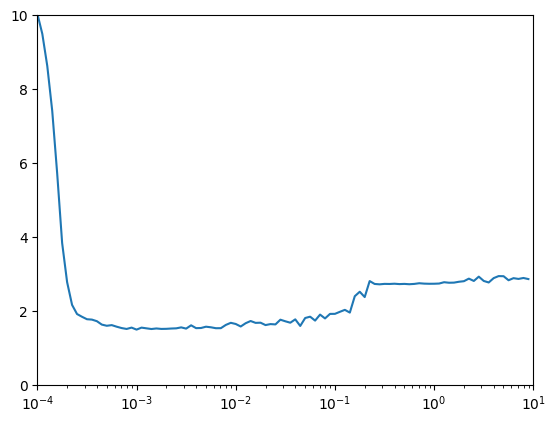

In [16]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

(0.0002, 0.1, 1.4, 2.0)

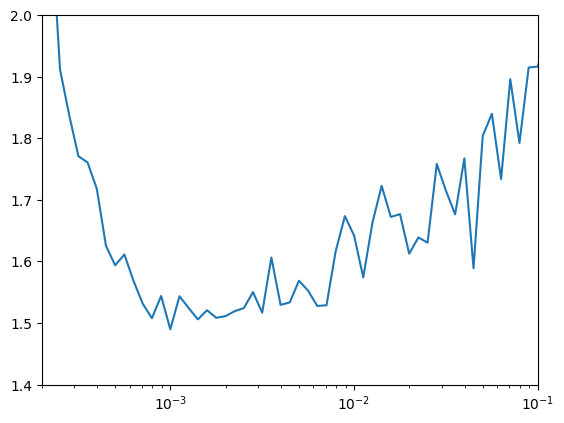

In [18]:
# Zoom in the above graph to determine the optimal learning rate
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([2e-4, 1e-1, 1.4, 2])

## Compiling the model

In [19]:
def create_model(lr):

    model = create_uncompiled_model()
    model.compile(loss='huber',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=["mae"])
    return model

In [20]:
# Define the optimal learning rate from the above graph
learning_rate = 1e-3

# Create the compiled model
model = create_model(learning_rate)

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 11s 75ms/step - loss: 5.4868 - mae: 5.9699
Epoch 2/50
77/77 [==============================] - 5s 59ms/step - loss: 2.5827 - mae: 3.0472
Epoch 3/50
77/77 [==============================] - 6s 74ms/step - loss: 1.9623 - mae: 2.4140
Epoch 4/50
77/77 [==============================] - 5s 58ms/step - loss: 1.7429 - mae: 2.1904
Epoch 5/50
77/77 [==============================] - 6s 71ms/step - loss: 1.6708 - mae: 2.1181
Epoch 6/50
77/77 [==============================] - 5s 59ms/step - loss: 1.5895 - mae: 2.0363
Epoch 7/50
77/77 [==============================] - 5s 58ms/step - loss: 1.5594 - mae: 2.0019
Epoch 8/50
77/77 [==============================] - 6s 75ms/step - loss: 1.5499 - mae: 1.9941
Epoch 9/50
77/77 [==============================] - 5s 67ms/step - loss: 1.5104 - mae: 1.9541
Epoch 10/50
77/77 [==============================] - 5s 58ms/step - loss: 1.5205 - mae: 1.9612
Epoch 11/50
77/77 [==============================] - 6s 75

## Evaluating the forecast

In [21]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

## Forecasting using batches of data

In [22]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

113/113 [==============================] - 3s 19ms/step


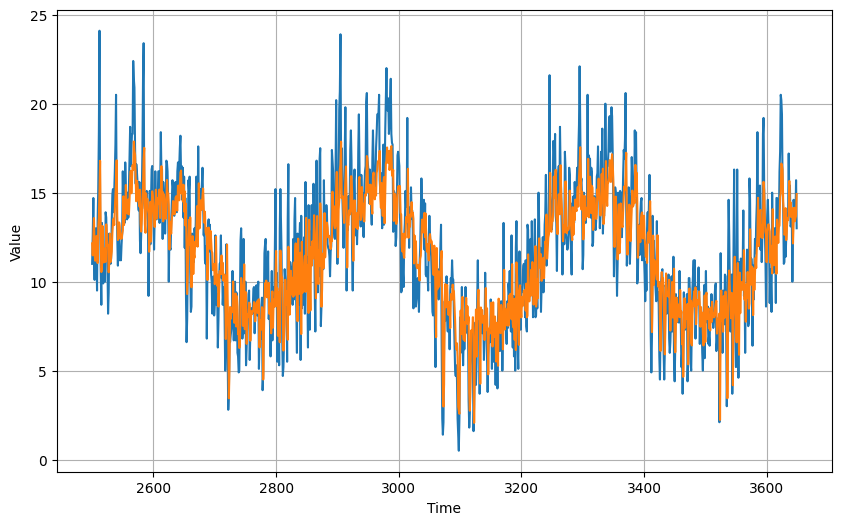

In [23]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [24]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.26, mae: 1.79 for forecast


## Saving the model

In [25]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.index
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/assets/
saved_model/my_model/saved_model.pb
saved_model/my_model/fingerprint.pb


In [26]:
# Save the model in the native Keras format
model.save('mymodel.keras')